# Connect to drive

### Run the cells below one by one!

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

/content
mkdir: cannot create directory ‘drive’: File exists
/content/drive
mkdir: cannot create directory ‘MyDrive’: File exists
/content
/
fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option


# Import libraries & Preparation

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, ZeroPadding2D,\
     Flatten, BatchNormalization, AveragePooling2D, Dense, Activation, Add, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Convolution2D
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

import random
import shutil
import cv2
import os
from PIL import Image

In [ ]:
ROOT_PATH = "./content/drive/MyDrive/CapstoneProject/ML"
DATASET_PATH = f"{ROOT_PATH}/tmp_dataset"
TARGET_PATH = f"{ROOT_PATH}/Dataset/data"
TRAINING_PATH = f"{ROOT_PATH}/Dataset/data/training4"
VALIDATION_PATH = f"{ROOT_PATH}/Dataset/data/validation4"

In [ ]:
classes = ['empty_bunch', 'overripe', 'ripe', 'rotten', 'underripe', 'unripe']

# Analyze Dataset

In [ ]:
def check_dataset(PATH, classes):
  '''
  Print number of images per class
  and total of images
  '''
  num_files = 0
  for cls in classes:
    length = len(os.listdir(os.path.join(PATH, cls)))
    print(f"Number of images for {cls}: {length}")
    num_files += length
  print("="*15)
  print("Number of images total:", num_files)

In [ ]:
check_dataset(DATASET_PATH, classes)

Number of images for empty_bunch: 102
Number of images for overripe: 188
Number of images for ripe: 176
Number of images for rotten: 96
Number of images for underripe: 178
Number of images for unripe: 174
Number of images total: 914


The data is unbalance.
Will use augmentation for `rotten` and `unripe` classes.

In [ ]:
def show_images_by_path(DATASET_PATH, cls):
  '''
  Show 6 images of the given class
  '''
  DIR = os.path.join(DATASET_PATH, cls)
  image_got = 0
  plt.figure(figsize=(36,6))
  for root, dirs, files in os.walk(DIR):
    for file in files:
      if image_got == 6:
        break
      image_got += 1
      img = mpimg.imread(os.path.join(root, file))
      plt.subplot(1, 6, image_got)
      plt.imshow(img)
  plt.show

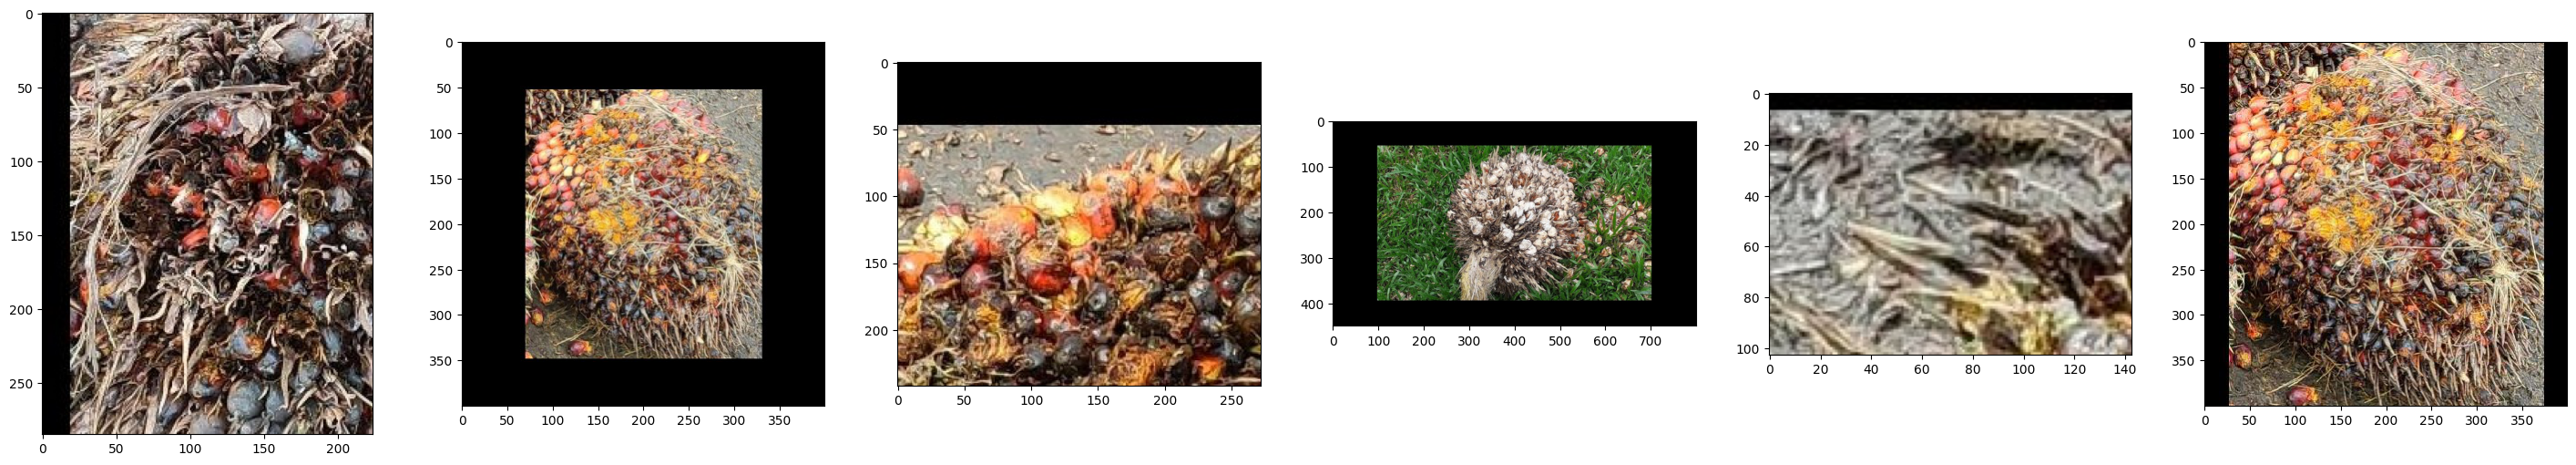

In [ ]:
show_images_by_path(DATASET_PATH, 'rotten')

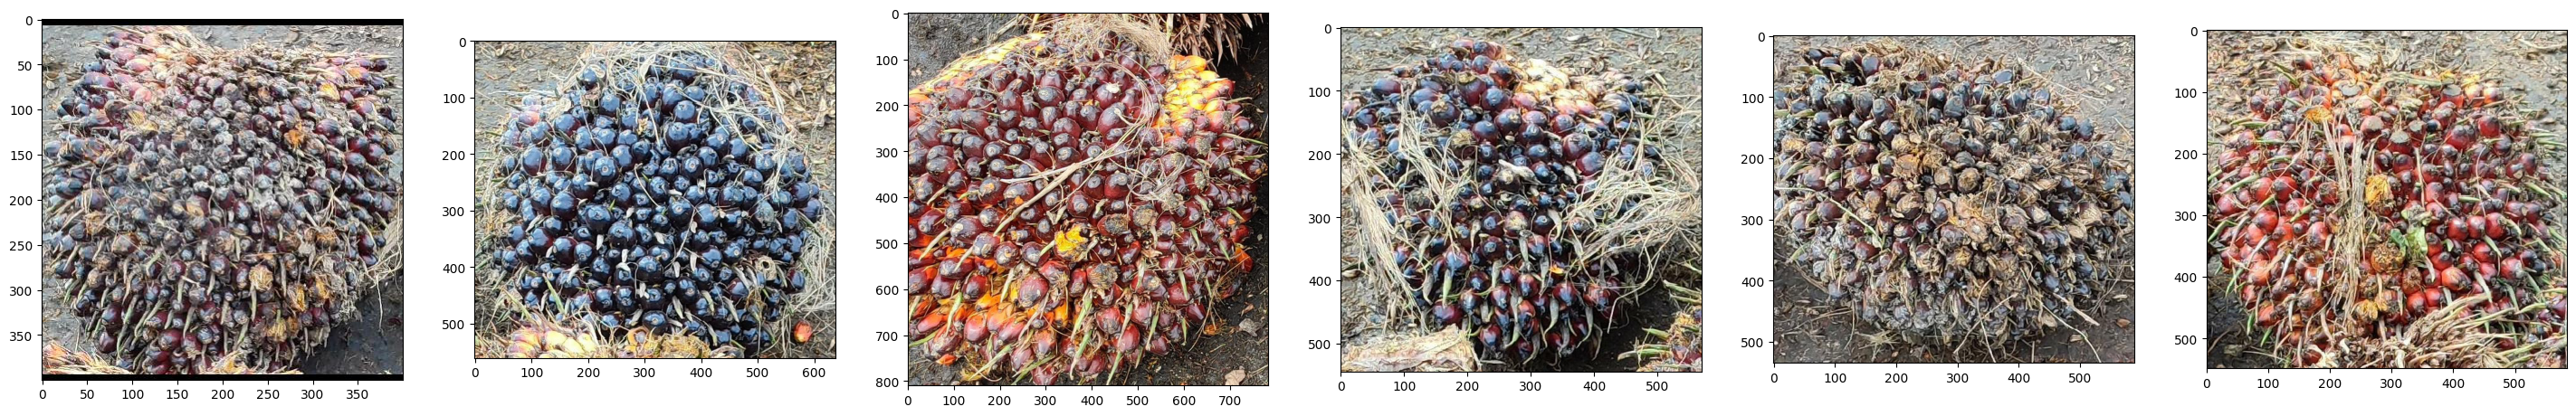

In [ ]:
show_images_by_path(DATASET_PATH, 'unripe')

# Prepare Dataset

In [ ]:
def compare_two_images(image1, image2):
  fig = plt.figure(figsize=(10, 7))
  fig.add_subplot(1, 2, 1)
  plt.imshow(image1)
  fig.add_subplot(1, 2, 2)
  plt.imshow(image2)
  plt.show()

In [ ]:
def show_images(images, num):
  image_got = 0
  plt.figure(figsize=(num*6,num))
  for idx, img in enumerate(images):
    plt.subplot(1, num, idx+1)
    plt.imshow(img)
  plt.show

In [ ]:
import os
import cv2
import numpy as np
import random

class ImageAugmentor:
  def __init__(self, image_folder):
    self.image_folder = image_folder
  
  def convert_to_RGB(self, image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

  def rotate_image(self, image, angle, cvt=False):
    if cvt:
      image = self.convert_to_RGB(image)
    height, width = image.shape[:2]
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    return rotated_image

  def shift_image(self, image, shift_x, shift_y, cvt=False):
    if cvt:
      image = self.convert_to_RGB(image)
    translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
    shifted_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return shifted_image

  def zoom_image(self, image, zoom_factor, cvt=False):
    if cvt:
      image = self.convert_to_RGB(image)
    height, width = image.shape[:2]
    zoom_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), 0, zoom_factor)
    zoomed_image = cv2.warpAffine(image, zoom_matrix, (width, height))
    return zoomed_image

  def crop_image(self, image, x, y, width, height, cvt=False):
    if cvt:
      image = self.convert_to_RGB(image)
    cropped_image = image[y:y+height, x:x+width]
    return cropped_image

  def augment_images(self, save_dir=None):
    image_files = os.listdir(self.image_folder)
    augmented_images = []

    for image_file in image_files:
      image_path = os.path.join(self.image_folder, image_file)
      image = self.convert_to_RGB(cv2.imread(image_path))

      # Rotate the image
      rotated_image = self.rotate_image(image, 45)
      augmented_images.append(rotated_image)

      # Shift the image
      shifted_image = self.shift_image(image, 50, 50)
      augmented_images.append(shifted_image)

      # Zoom the image
      zoomed_image = self.zoom_image(image, 1.5)
      augmented_images.append(zoomed_image)

      # Crop the image
      cropped_image = self.crop_image(image, 100, 100, 300, 300)
      augmented_images.append(cropped_image)

      if save_dir:
        # Save the augmented images
        save_path = os.path.join(save_dir, f"augmented_{image_file}")
        cv2.imwrite(save_path, cropped_image)

    return augmented_images

  def augment_images_randomized(self, save_dir=None, cvt=False):
    image_files = os.listdir(self.image_folder)
    augmented_images = []
    real_images = []

    for image_file in image_files:
      image_path = os.path.join(self.image_folder, image_file)
      image = cv2.imread(image_path)
      if cvt:
        image = self.convert_to_RGB(image)

      # Generate random parameters
      angle = random.uniform(-30, 30)
      shift_x = random.randint(-50, 50)
      shift_y = random.randint(-50, 50)
      zoom_factor = random.uniform(0.7, 1.3)
      crop_x = random.randint(0, max(0, image.shape[1] - 300))
      crop_y = random.randint(0, max(0, image.shape[0] - 300))
      crop_width = random.randint(100, min(image.shape[1], 300))
      crop_height = random.randint(100, min(image.shape[0], 300))

      # Rotate the image
      rotated_image = self.rotate_image(image, angle)
      augmented_images.append(rotated_image)
      real_images.append(image)

      # Shift the image
      shifted_image = self.shift_image(image, shift_x, shift_y)
      augmented_images.append(shifted_image)
      real_images.append(image)

      # Zoom the image
      zoomed_image = self.zoom_image(image, zoom_factor)
      augmented_images.append(zoomed_image)
      real_images.append(image)

      # Crop the image
      cropped_image = self.crop_image(image, crop_x, crop_y, crop_width, crop_height)
      augmented_images.append(cropped_image)
      real_images.append(image)

      if save_dir:
        # Save the augmented images
        save_path = os.path.join(save_dir, f"augmented_cropped_{image_file}")
        cv2.imwrite(save_path, cropped_image)
      
      if save_dir:
        # Save the augmented images
        save_path = os.path.join(save_dir, f"augmented_zoomed_{image_file}")
        cv2.imwrite(save_path, zoomed_image)

    return augmented_images, real_images

In [ ]:
augmentor = ImageAugmentor(os.path.join(DATASET_PATH, 'rotten'))

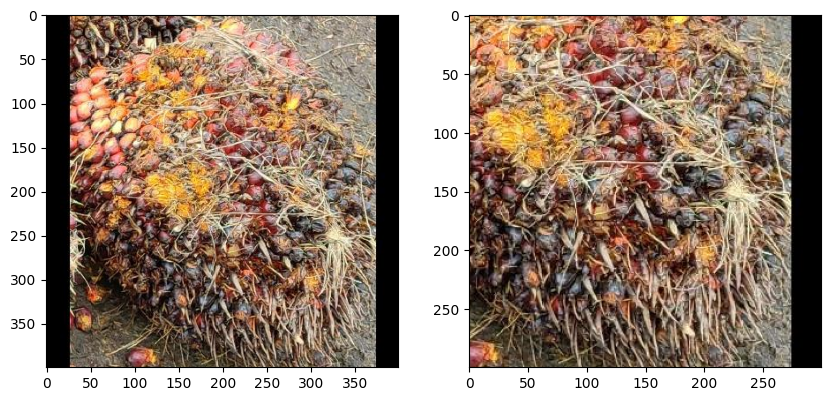

In [ ]:
_path = os.path.join(DATASET_PATH + '/rotten', os.listdir(DATASET_PATH + '/rotten')[0])
img = cv2.imread(_path)
aug_img = augmentor.crop_image(img, 100, 100, 500, 500, True)
compare_two_images(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), aug_img)

In [ ]:
aug_images, real_images = augmentor.augment_images_randomized(cvt=True)

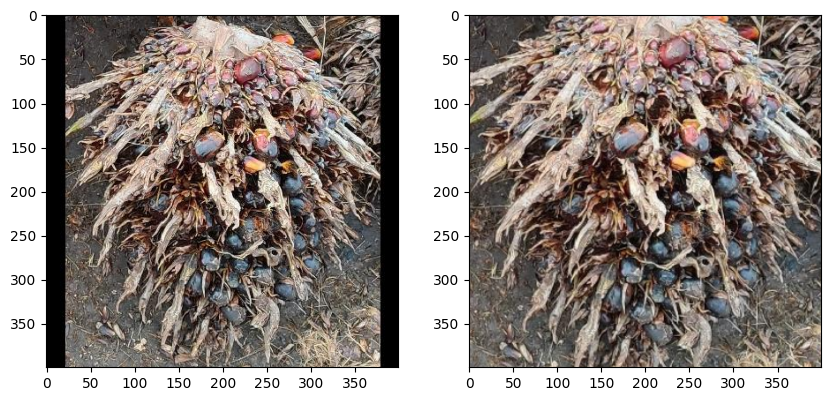

In [ ]:
compare_two_images(real_images[106], aug_images[106])

In [ ]:
augmentor.augment_images_randomized(save_dir=os.path.join(DATASET_PATH, 'rotten'), cvt=False)

In [ ]:
check_dataset(DATASET_PATH, classes)

Number of images for empty_bunch: 102
Number of images for overripe: 188
Number of images for ripe: 176
Number of images for rotten: 96
Number of images for underripe: 178
Number of images for unripe: 58
Number of images total: 798


In [ ]:
augmentor = ImageAugmentor(os.path.join(DATASET_PATH, 'unripe'))
augmentor.augment_images_randomized(save_dir=os.path.join(DATASET_PATH, 'unripe'), cvt=False)

In [ ]:
check_dataset(DATASET_PATH, classes)

Number of images for empty_bunch: 102
Number of images for overripe: 188
Number of images for ripe: 176
Number of images for rotten: 96
Number of images for underripe: 178
Number of images for unripe: 174
Number of images total: 914


## Split Dataset

In [ ]:
TARGET_DIR = "./content/drive/MyDrive/CapstoneProject/ML/Dataset/data"

def create_train_val_dirs(root_path, target_dir_exists=True):
  """
  Creates directories for the train and test sets
  
  Args:
    root_path (string) - the base directory path to create subdirectories from
  
  Returns:
    None
  """

  if not target_dir_exists:
    os.makedirs(TARGET_DIR)
  os.makedirs(os.path.join(root_path, 'training4'))
  os.makedirs(os.path.join(root_path, 'validation4'))

  classes = ['empty_bunch', 'overripe', 'ripe', 'rotten', 'underripe', 'unripe']

  # Directory with training
  for cls in classes:
    sub_path = "training4/" + cls
    os.makedirs(os.path.join(root_path, sub_path))

  # Directory with validation
  for cls in classes:
    sub_path = "validation4/" + cls
    os.makedirs(os.path.join(root_path, sub_path))
  

In [ ]:
try:
  create_train_val_dirs(root_path=TARGET_DIR)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [ ]:
for rootdir, dirs, files in os.walk(TARGET_DIR + '/training4'):
  for subdir in dirs:
    print(os.path.join(rootdir, subdir))

for rootdir, dirs, files in os.walk(TARGET_DIR + '/validation4'):
  for subdir in dirs:
    print(os.path.join(rootdir, subdir))

./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/training4/overripe
./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/training4/ripe
./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/training4/rotten
./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/training4/unripe
./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/training4/empty_bunch
./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/training4/underripe
./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/validation4/empty_bunch
./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/validation4/overripe
./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/validation4/ripe
./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/validation4/rotten
./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/validation4/underripe
./content/drive/MyDrive/CapstoneProject/ML/Dataset/data/validation4/unripe


In [ ]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  """
  Splits the data into train and test sets
  
  Args:
    SOURCE_DIR (string): directory path containing the images
    TRAINING_DIR (string): directory path to be used for training
    VALIDATION_DIR (string): directory path to be used for validation
    SPLIT_SIZE (float): proportion of the dataset to be used for training
    
  Returns:
    None
  """
  ### START CODE HERE
  content = random.sample(os.listdir(SOURCE_DIR), len(os.listdir(SOURCE_DIR)))
  # content = os.listdir(SOURCE_DIR)
  train_size = int(len(content) * SPLIT_SIZE)
  for i, image_name in enumerate(content):
    if os.path.getsize(os.path.join(SOURCE_DIR, image_name)) == 0:
      print(image_name, "is zero length, so ignoring.")
      continue
    if i < train_size:
        shutil.copyfile(os.path.join(SOURCE_DIR, image_name), os.path.join(TRAINING_DIR, image_name))
    else:
        shutil.copyfile(os.path.join(SOURCE_DIR, image_name), os.path.join(VALIDATION_DIR, image_name))

In [ ]:
classes = ['empty_bunch', 'overripe', 'ripe', 'rotten', 'underripe', 'unripe']

TRAINING_DIR = os.path.join(TARGET_DIR, "training4")
VALIDATION_DIR = os.path.join(TARGET_DIR, "validation4")

# # Uncomment this code
# # Empty directories in case you run this cell multiple times
# for cls in classes:
#   cls_dir = os.path.join(TRAINING_DIR, cls)
#   if len(os.listdir(cls_dir)) > 0:
#     for file in os.scandir(cls_dir):
#       os.remove(file.path)

# for cls in classes:
#   cls_dir = os.path.join(VALIDATION_DIR, cls)
#   if len(os.listdir(cls_dir)) > 0:
#     for file in os.scandir(cls_dir):
#       os.remove(file.path)

# Define proportion of images used for training
split_size = .8

for cls in classes:
  train_cls_dir = os.path.join(TRAINING_DIR, cls)
  val_cls_dir = os.path.join(VALIDATION_DIR, cls)
  src_cls_dir = os.path.join(DATASET_PATH, cls)
  split_data(src_cls_dir, train_cls_dir, val_cls_dir, split_size)

In [ ]:
print("Training")
check_dataset(TRAINING_DIR, classes)
print("="*15)
print("Validation")
check_dataset(VALIDATION_DIR, classes)

Training
Number of images for empty_bunch: 81
Number of images for overripe: 150
Number of images for ripe: 140
Number of images for rotten: 76
Number of images for underripe: 142
Number of images for unripe: 139
Number of images total: 728
Validation
Number of images for empty_bunch: 21
Number of images for overripe: 38
Number of images for ripe: 36
Number of images for rotten: 20
Number of images for underripe: 36
Number of images for unripe: 35
Number of images total: 186
